# Install Libraries

In [ ]:
# !pip install tensorflow pandas numpy sklearn
# !pip install pandas scikit-learn
# !pip install lime shap

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.metrics import AUC, Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.tseries.offsets import DateOffset

# Read Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path_AU_preprocessed = '/content/drive/MyDrive/CKD/GitHub/data/preprocessed/AU/AU_preprocessed_df.csv'
file_path_JP_preprocessed = '/content/drive/MyDrive/CKD/GitHub/data/preprocessed/JP/JP_preprocessed_df.csv'

# Preparing for Tree Based Model

## Pre-processing Australian Dataset for tree based models

In [ ]:
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def process_au_dataframe(file_path):
    AU_df = pd.read_csv(file_path)
    AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
    AU_df = AU_df.reset_index(drop=True)

    # Convert 'COLLECTED' to float for calculation purposes
    AU_df['COLLECTED'] = AU_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID'
    grouped = AU_df.groupby('ID')

    # Compute slopes for each group and directly assign them to the DataFrame
    AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

    # Calculate mean and std for eGFR
    AU_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    AU_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    AU_df.fillna(0, inplace=True)

    return AU_df

## Pre-processing Japanese Dataset for tree based models

In [ ]:
# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    model = LinearRegression().fit(x, y)
    return model.coef_[0]

def process_dataframe(file_path):
    JP_df = pd.read_csv(file_path)
    JP_df = JP_df.reset_index(drop=True)

    # Apply the function to the 'Time' column to create a new 'Months' column
    JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

    # Assume a starting date for all IDs
    start_date = pd.Timestamp('2020-01-01')

    # Create a 'COLLECTED' column based on the 'Months' column
    JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

    # Convert 'COLLECTED' to float for calculation purposes
    JP_df['COLLECTED'] = JP_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID' and calculate slopes, mean, and std for eGFR
    grouped = JP_df.groupby('ID')
    JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']
    JP_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    JP_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    JP_df.fillna(0, inplace=True)

    return JP_df

# Train and Evaluate Models

### TUNED HYPERPARAMTER MODEL - AU Dataset

In [ ]:
AU_df = process_au_dataframe(file_path_AU_preprocessed)
AU_df

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


,COLLECTED,ID,SEX,AGE,eGFR,Kidney_Failure,eGFR_slope,eGFR_mean,eGFR_std
0,737062.510417,2,1,45,23,1,-0.045462,18.055556,2.099642
1,737098.010417,2,1,46,19,1,-0.045462,18.055556,2.099642
2,737100.036806,2,1,46,17,1,-0.045462,18.055556,2.099642
3,737115.687500,2,1,46,15,1,-0.045462,18.055556,2.099642
4,737122.458333,2,1,46,15,1,-0.045462,18.055556,2.099642
...,...,...,...,...,...,...,...,...,...
154511,738609.187500,149302,1,84,55,0,-2.396167,52.666667,2.516611
154512,738610.229167,149302,1,84,50,0,-2.396167,52.666667,2.516611
154513,738608.819444,149311,1,72,55,0,-3.435050,50.666667,3.785939
154514,738609.329167,149311,1,72,48,0,-3.435050,50.666667,3.785939


In [ ]:
# Check the best seed value

# Adjust this threshold as needed
threshold = 0.5

# Create an empty dictionary to store ensemble components as well as their test statistics
ensemble = {}

features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = AU_df[features]
y = AU_df['Kidney_Failure']

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'TPR', 'TNR', 'FPR', 'FNR', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'ROC-AUC'])

# Here we are varying the training and testing sets
for seed_value in range(10):
    random.seed(seed_value)
    np.random.seed(seed_value)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed_value, stratify=y)

    # Define the model
    model = DecisionTreeClassifier(random_state=seed_value)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_probabilities = model.predict_proba(X_test)[:,1]  # Assuming class 1 is the positive class

    # Apply threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Compute statistics
    true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
    true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
    false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
    false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    specificity = tnr
    roc_auc = roc_auc_score(y_test, predicted_probabilities)

    df_results.loc[seed_value] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, specificity, roc_auc]

    ensemble[seed_value] = {'model': model,
                            'test_statistics': {'true_positives': true_positives,
                                                'true_negatives': true_negatives,
                                                'false_positives': false_positives,
                                                'false_negatives': false_negatives,
                                                'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
                                                'accuracy': accuracy,
                                                'precision': precision,
                                                'recall': recall,
                                                'specificity': specificity,
                                                'roc_auc': roc_auc}}

# Print the average of each statistic over the 10 runs
print(df_results.mean())

TruePositives      2718.900000
TrueNegatives     74438.700000
FalsePositives       47.900000
FalseNegatives       52.500000
TPR                   0.981056
TNR                   0.999357
FPR                   0.000643
FNR                   0.018944
Accuracy              0.998700
Precision             0.982703
Recall                0.981056
Specificity           0.999357
ROC-AUC               0.990210
dtype: float64


In [ ]:
ensemble

{0: {'model': DecisionTreeClassifier(random_state=0),
  'test_statistics': {'true_positives': 2723,
   'true_negatives': 74439,
   'false_positives': 48,
   'false_negatives': 48,
   'tpr': 0.9826777336701552,
   'tnr': 0.9993555922509968,
   'fpr': 0.0006444077490031818,
   'fnr': 0.01732226632984482,
   'accuracy': 0.9987574102358332,
   'precision': 0.9826777336701552,
   'recall': 0.9826777336701552,
   'specificity': 0.9993555922509968,
   'roc_auc': 0.9910232592641838}},
 1: {'model': DecisionTreeClassifier(random_state=1),
  'test_statistics': {'true_positives': 2726,
   'true_negatives': 74424,
   'false_positives': 62,
   'false_negatives': 46,
   'tpr': 0.9834054834054834,
   'tnr': 0.9991676288161534,
   'fpr': 0.0008323711838466289,
   'fnr': 0.016594516594516596,
   'accuracy': 0.9986020865153123,
   'precision': 0.9777618364418939,
   'recall': 0.9834054834054834,
   'specificity': 0.9991676288161534,
   'roc_auc': 0.9912996085263358}},
 2: {'model': DecisionTreeClassifie

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Final Accuracy: 0.9975731296919492
Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29795
           1       0.96      0.97      0.97      1109

    accuracy                           1.00     30904
   macro avg       0.98      0.99      0.98     30904
weighted avg       1.00      1.00      1.00     30904

Final ROC-AUC Score:
0.9961833726738968
0.9975731296919492 0.9583333333333334 0.9747520288548241 0.966472954850246 0.9984225541198187 0.9961833726738968
Final Accuracy: 0.9979290036566029
Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29794
           1       0.97      0.97      0.97      1109

    accuracy                           1.00     30903
   macro avg       0.98      0.99      0.99     30903
weighted avg       1.00      1.00      1.00     30903

F

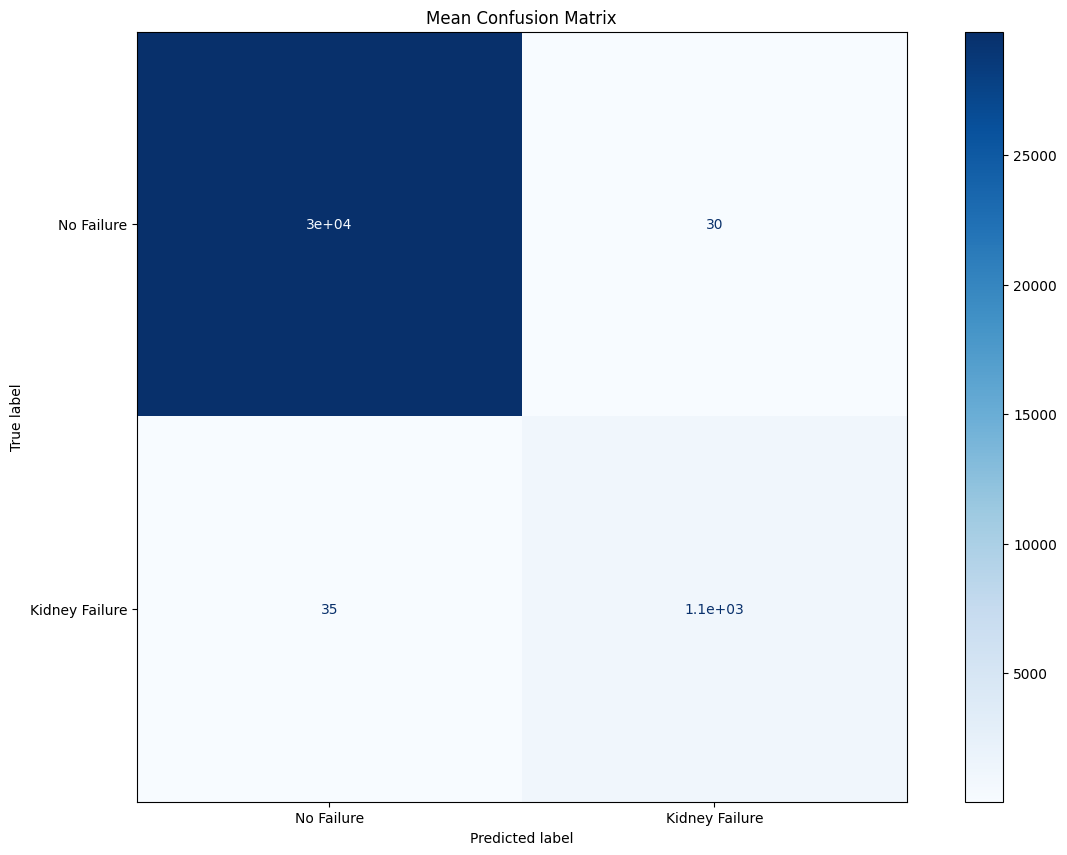

                        Mean  Standard Deviation
TruePositives    1073.400000            7.797435
TrueNegatives   29764.400000           11.193748
FalsePositives     30.200000           11.366618
FalseNegatives     35.200000            7.463243
TPR                 0.968247            0.006742
TNR                 0.998986            0.000381
FPR                 0.001014            0.000381
FNR                 0.031753            0.006742
Accuracy            0.997884            0.000271
Precision           0.972752            0.009825
Recall              0.968247            0.006742
f1_score            0.970447            0.003683
Specificity         0.998986            0.000381
ROC-AUC             0.997557            0.001119
Best hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}


In [ ]:
# Given the best seed, find the optimial hyperparameters.

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
                                   'TPR', 'TNR', 'FPR', 'FNR',
                                   'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# Sample dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = AU_df[features]
y = AU_df['Kidney_Failure']

# Initialize accumulators for confusion matrix elements
total_true_positives = 0
total_true_negatives = 0
total_false_positives = 0
total_false_negatives = 0

# Initialize a Decision Tree model
clf = DecisionTreeClassifier(random_state=seed_value)

param_grid = {
    #'ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2', None],
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'class_weight': ['balanced', None]
}

# Initialize GridSearch
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value),
                           scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the GridSearch model
grid_search.fit(X, y)

# Extract the best estimator
best_clf = grid_search.best_estimator_

# Use Stratified KFold for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train a Decision Tree model using the best estimator
    best_clf.fit(X_train, y_train)

    # Evaluate on the held-out test set
    y_pred = best_clf.predict(X_test)
    print("Final Accuracy:", accuracy_score(y_test, y_pred))
    print("Final Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Final ROC-AUC Score:")
    print(roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1]))

    # Compute the statistics
    true_positives = np.sum((y_pred == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred == 0) & (y_test == 0))
    false_positives = np.sum((y_pred == 1) & (y_test == 0))
    false_negatives = np.sum((y_pred == 0) & (y_test == 1))

    # Accumulate confusion matrix values
    total_true_positives += true_positives
    total_true_negatives += true_negatives
    total_false_positives += false_positives
    total_false_negatives += false_negatives

    # Print individual metrics
    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)
    specificity = true_negatives / (true_negatives + false_positives)
    roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])

    print(accuracy, precision, recall, f1_score, specificity, roc_auc)

    # Add the statistics to the dataframe
    df_results.loc[len(df_results)] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, f1_score, specificity, roc_auc]

# Compute mean confusion matrix values
mean_true_positives = total_true_positives / n_splits
mean_true_negatives = total_true_negatives / n_splits
mean_false_positives = total_false_positives / n_splits
mean_false_negatives = total_false_negatives / n_splits

# Construct the mean confusion matrix
mean_confusion_matrix = np.array([[mean_true_negatives, mean_false_positives],
                                 [mean_false_negatives, mean_true_positives]])

# Plot the mean confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_confusion_matrix, display_labels=['No Failure', 'Kidney Failure'])
cm_display.plot(cmap='Blues')  # Using the 'Blues' colormap
plt.title('Mean Confusion Matrix')
plt.show()

# Print the average of each statistic over the 5 folds
#print(df_results.mean())

# Print the average and standard deviation of each statistic over the 5 folds
mean_results = df_results.mean()
std_results = df_results.std()

# Create a new DataFrame to display mean and standard deviation
results_summary = pd.DataFrame(index=mean_results.index)
results_summary['Mean'] = mean_results
results_summary['Standard Deviation'] = std_results

print(results_summary)

# Print out the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

In [ ]:
# Train the final model on the full Australian dataset with the most optimal hyperparameters.
best_clf = DecisionTreeClassifier(**best_params, random_state=seed_value)
best_clf.fit(X, y)

DecisionTreeClassifier(max_depth=15, min_samples_split=10, random_state=0)

In [ ]:
# Get feature importances
importances = best_clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR_mean (0.483001)
2.	feature eGFR_slope (0.330757)
3.	feature AGE (0.165686)
4.	feature SEX (0.020556)


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is the trained decision tree
plt.figure(figsize=(400, 30))
plot_tree(best_clf, filled=True, feature_names=features, class_names=str(best_clf.classes_), rounded=True, fontsize=10)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.tree import _tree

def tree_to_ifelse(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else: # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return class = {tree_.value[node].argmax()}")

    recurse(0, 0)

# Using the function
tree_to_ifelse(best_clf, features)

if eGFR_mean <= 28.44:
  if eGFR_slope <= -0.00:
    if AGE <= 84.50:
      if eGFR_mean <= 21.07:
        if AGE <= 68.50:
          if eGFR_slope <= -0.86:
            if AGE <= 57.00:
              return class = 1
            else: # if AGE > 57.00
              if AGE <= 62.50:
                if SEX <= 1.50:
                  return class = 1
                else: # if SEX > 1.50
                  if eGFR_mean <= 17.50:
                    return class = 0
                  else: # if eGFR_mean > 17.50
                    return class = 0
              else: # if AGE > 62.50
                return class = 0
          else: # if eGFR_slope > -0.86
            if eGFR_slope <= -0.01:
              if SEX <= 1.50:
                if AGE <= 42.50:
                  if eGFR_mean <= 20.43:
                    return class = 0
                  else: # if eGFR_mean > 20.43
                    return class = 1
                else: # if AGE > 42.50
                  if eGFR_slope <= -0.5

### HELD-OUT TEST DATA - Tuned Model (Without Fine-Tuning)

In [ ]:
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


,ID,SEX,Time,AGE,eGFR,Kidney_Failure,Months,COLLECTED,eGFR_slope,eGFR_mean,eGFR_std
0,10101,2,eGFR(0M),74,44.685607,0,0,737425.0,-0.015137,29.643276,7.328739
1,10101,2,eGFR(6M),74,33.702778,0,6,737607.0,-0.015137,29.643276,7.328739
2,10101,2,eGFR(12M),75,30.641655,0,12,737791.0,-0.015137,29.643276,7.328739
3,10101,2,eGFR(18M),75,31.129969,0,18,737972.0,-0.015137,29.643276,7.328739
4,10101,2,eGFR(24M),76,26.807906,0,24,738156.0,-0.015137,29.643276,7.328739
...,...,...,...,...,...,...,...,...,...,...,...
3383,160112,1,eGFR(18M),53,35.133304,0,18,737972.0,-0.001151,36.370115,2.238376
3384,160112,1,eGFR(24M),54,35.502557,0,24,738156.0,-0.001151,36.370115,2.238376
3385,160112,1,eGFR(30M),54,33.338440,0,30,738337.0,-0.001151,36.370115,2.238376
3386,160112,1,eGFR(36M),55,36.758771,0,36,738521.0,-0.001151,36.370115,2.238376


In [ ]:
# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X_test = JP_df[features]
y_test = JP_df['Kidney_Failure']

# Evaluate on the held-out test set
clf = best_clf

y_pred = clf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("Final ROC-AUC Score:")
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Compute the statistics
true_positives = np.sum((y_pred == 1) & (y_test == 1))
true_negatives = np.sum((y_pred == 0) & (y_test == 0))
false_positives = np.sum((y_pred == 1) & (y_test == 0))
false_negatives = np.sum((y_pred == 0) & (y_test == 1))

# Print individual metrics
tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("TPR: {:.6g}".format(tpr), "TNR: {:.6g}".format(tnr), "FPR: {:.6g}".format(fpr), "FNR: {:.6g}".format(fnr),
      '\n' "Accuracy: {:.6g}".format(accuracy), "Precision: {:.6g}".format(precision), "Recall: {:.6g}".format(recall), "F1 Score: {:.6g}".format(f1_score), "Specificity: {:.6g}".format(specificity), "ROC-AUC: {:.6g}".format(roc_auc))

Final Accuracy: 0.8627508854781583
Final Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2932
           1       0.49      0.42      0.45       456

    accuracy                           0.86      3388
   macro avg       0.70      0.68      0.69      3388
weighted avg       0.85      0.86      0.86      3388

Final ROC-AUC Score:
0.6960247331322851
TPR: 0.421053 TNR: 0.931446 FPR: 0.0685539 FNR: 0.578947 
Accuracy: 0.862751 Precision: 0.48855 Recall: 0.421053 F1 Score: 0.452297 Specificity: 0.931446 ROC-AUC: 0.696025


### HELD-OUT TEST DATA - Tuned Model (with Fine Tuning)

In [ ]:
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


,ID,SEX,Time,AGE,eGFR,Kidney_Failure,Months,COLLECTED,eGFR_slope,eGFR_mean,eGFR_std
0,10101,2,eGFR(0M),74,44.685607,0,0,737425.0,-0.015137,29.643276,7.328739
1,10101,2,eGFR(6M),74,33.702778,0,6,737607.0,-0.015137,29.643276,7.328739
2,10101,2,eGFR(12M),75,30.641655,0,12,737791.0,-0.015137,29.643276,7.328739
3,10101,2,eGFR(18M),75,31.129969,0,18,737972.0,-0.015137,29.643276,7.328739
4,10101,2,eGFR(24M),76,26.807906,0,24,738156.0,-0.015137,29.643276,7.328739
...,...,...,...,...,...,...,...,...,...,...,...
3383,160112,1,eGFR(18M),53,35.133304,0,18,737972.0,-0.001151,36.370115,2.238376
3384,160112,1,eGFR(24M),54,35.502557,0,24,738156.0,-0.001151,36.370115,2.238376
3385,160112,1,eGFR(30M),54,33.338440,0,30,738337.0,-0.001151,36.370115,2.238376
3386,160112,1,eGFR(36M),55,36.758771,0,36,738521.0,-0.001151,36.370115,2.238376


Final Accuracy: 0.9333333333333333
Final Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2492
           1       0.74      0.77      0.76       388

    accuracy                           0.93      2880
   macro avg       0.85      0.87      0.86      2880
weighted avg       0.93      0.93      0.93      2880

Final ROC-AUC Score:
0.9444583491916401
TPR: 0.773196 TNR: 0.958266 FPR: 0.0417335 FNR: 0.226804 
Accuracy: 0.933333 Precision: 0.742574 Recall: 0.773196 F1 Score: 0.757576 Specificity: 0.958266 ROC-AUC: 0.944458


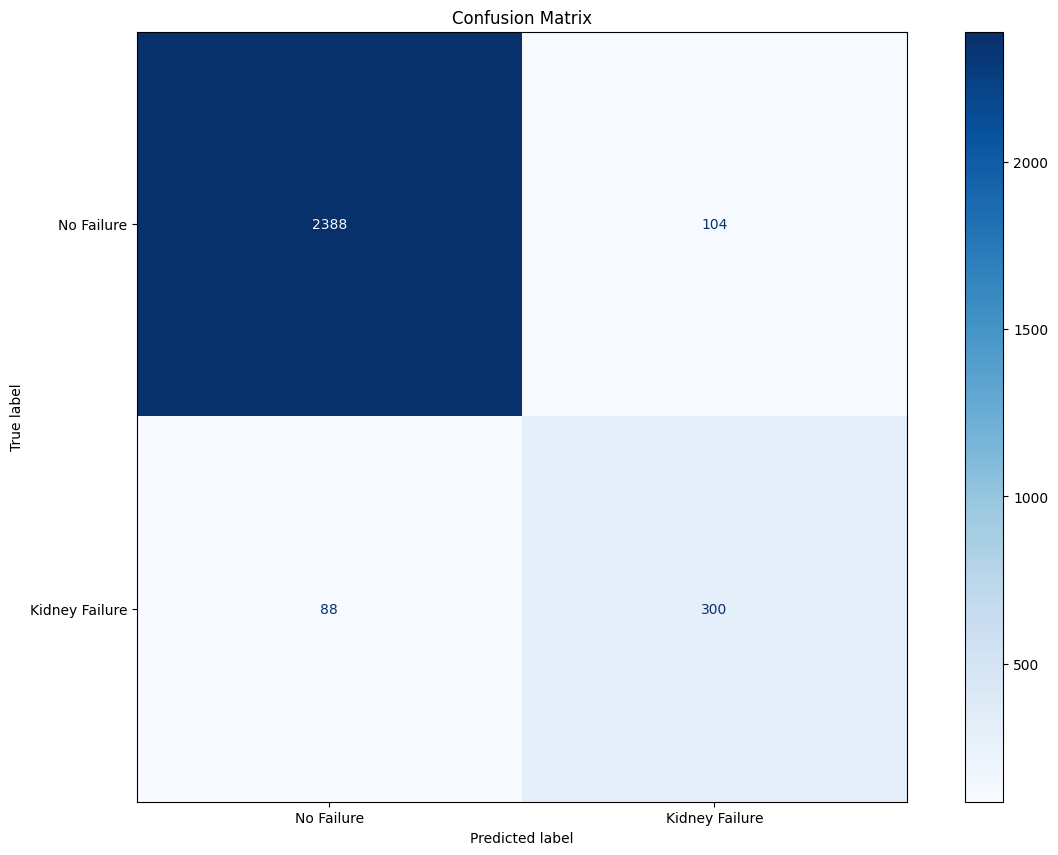

In [ ]:
# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# CHANGING TO TUNED MODEL
clf = best_clf

# Adjust this threshold as needed
threshold = 0.5

# Dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = JP_df[features]
y = JP_df['Kidney_Failure']

# Train the model on 15% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=seed_value, stratify=y)
clf.fit(X_train, y_train)

# Evaluate on the held-out test set
y_pred = clf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("Final ROC-AUC Score:")
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Compute the statistics
true_positives = np.sum((y_pred == 1) & (y_test == 1))
true_negatives = np.sum((y_pred == 0) & (y_test == 0))
false_positives = np.sum((y_pred == 1) & (y_test == 0))
false_negatives = np.sum((y_pred == 0) & (y_test == 1))

# Print individual metrics
tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("TPR: {:.6g}".format(tpr), "TNR: {:.6g}".format(tnr), "FPR: {:.6g}".format(fpr), "FNR: {:.6g}".format(fnr),
      '\n' "Accuracy: {:.6g}".format(accuracy), "Precision: {:.6g}".format(precision), "Recall: {:.6g}".format(recall), "F1 Score: {:.6g}".format(f1_score), "Specificity: {:.6g}".format(specificity), "ROC-AUC: {:.6g}".format(roc_auc))

# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Failure', 'Kidney Failure'])

cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get feature importances
importances = best_clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR_slope (0.507686)
2.	feature eGFR_mean (0.450605)
3.	feature AGE (0.041708)
4.	feature SEX (0.000000)


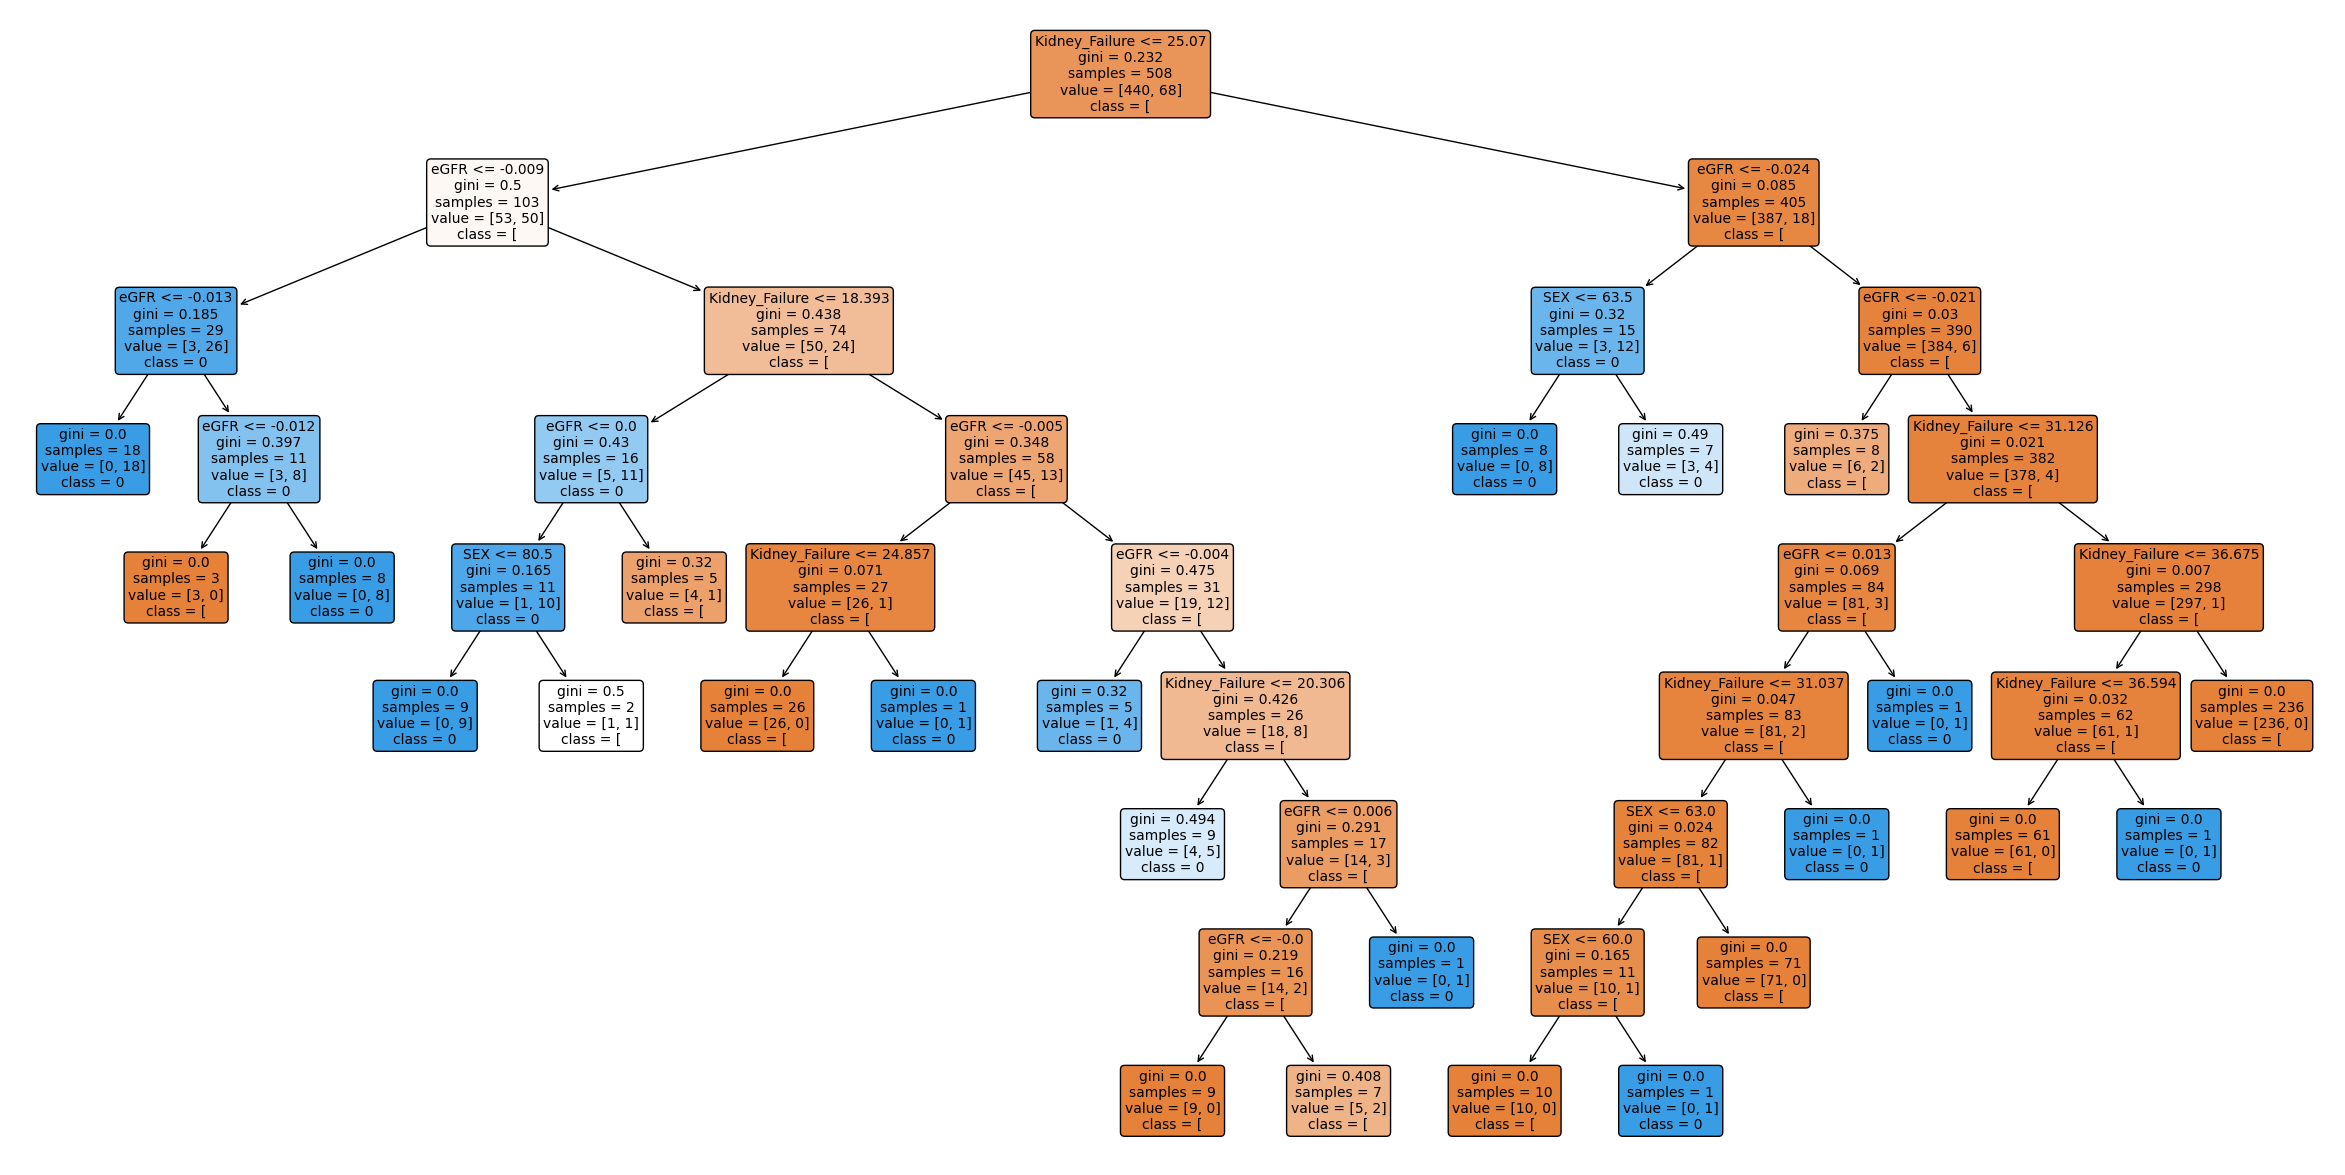

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is the trained decision tree
plt.figure(figsize=(30, 15))
plot_tree(best_clf, filled=True, feature_names=features, class_names=str(best_clf.classes_), rounded=True, fontsize=10)
plt.show()

In [ ]:
from sklearn.tree import _tree

def tree_to_ifelse(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else: # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return class = {tree_.value[node].argmax()}")

    recurse(0, 0)

# Using the function
tree_to_ifelse(best_clf, features)

if Kidney_Failure <= 25.07:
  if eGFR <= -0.01:
    if eGFR <= -0.01:
      return class = 1
    else: # if eGFR > -0.01
      if eGFR <= -0.01:
        return class = 0
      else: # if eGFR > -0.01
        return class = 1
  else: # if eGFR > -0.01
    if Kidney_Failure <= 18.39:
      if eGFR <= 0.00:
        if SEX <= 80.50:
          return class = 1
        else: # if SEX > 80.50
          return class = 0
      else: # if eGFR > 0.00
        return class = 0
    else: # if Kidney_Failure > 18.39
      if eGFR <= -0.00:
        if Kidney_Failure <= 24.86:
          return class = 0
        else: # if Kidney_Failure > 24.86
          return class = 1
      else: # if eGFR > -0.00
        if eGFR <= -0.00:
          return class = 1
        else: # if eGFR > -0.00
          if Kidney_Failure <= 20.31:
            return class = 1
          else: # if Kidney_Failure > 20.31
            if eGFR <= 0.01:
              if eGFR <= -0.00:
                return class = 0
              el

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create an explainer object
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=features,
                                 class_names=['No Kidney Failure', 'Kidney Failure'],
                                 discretize_continuous=True)

# Get an instance to interpret
i = random.randint(0, len(X_test)-1)
exp = explainer.explain_instance(X_test.iloc[i].values, best_clf.predict_proba)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

true_value = y_test.iloc[i]
print(f"True Value for instance {i}: {true_value}")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # Set the desired width and height

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


True Value for instance 1577: 0


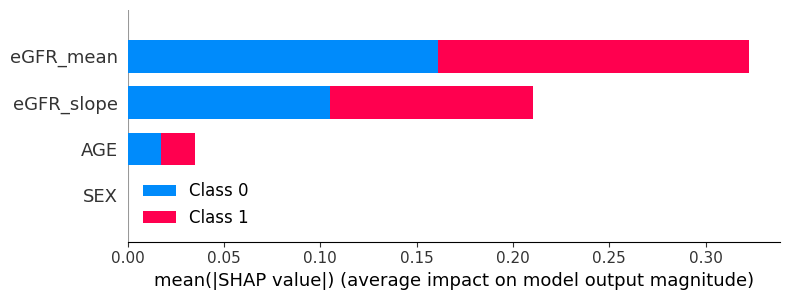

In [ ]:
import shap

# Initialize SHAP's tree explainer with the model
explainer = shap.TreeExplainer(best_clf)

# Compute SHAP values for a sample from the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# For individual predictions, you can use a force plot
# Here, for instance 'i' from LIME example
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])

# Data Analysis

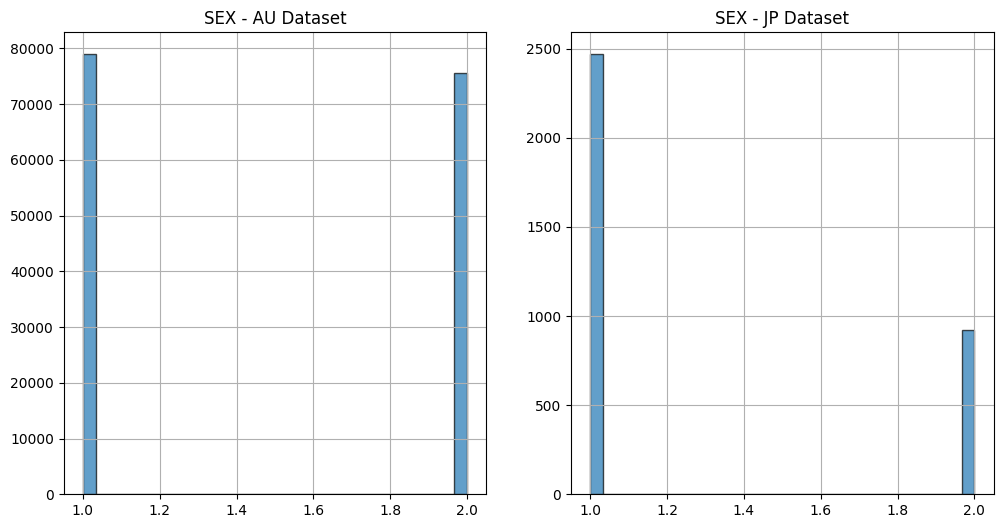

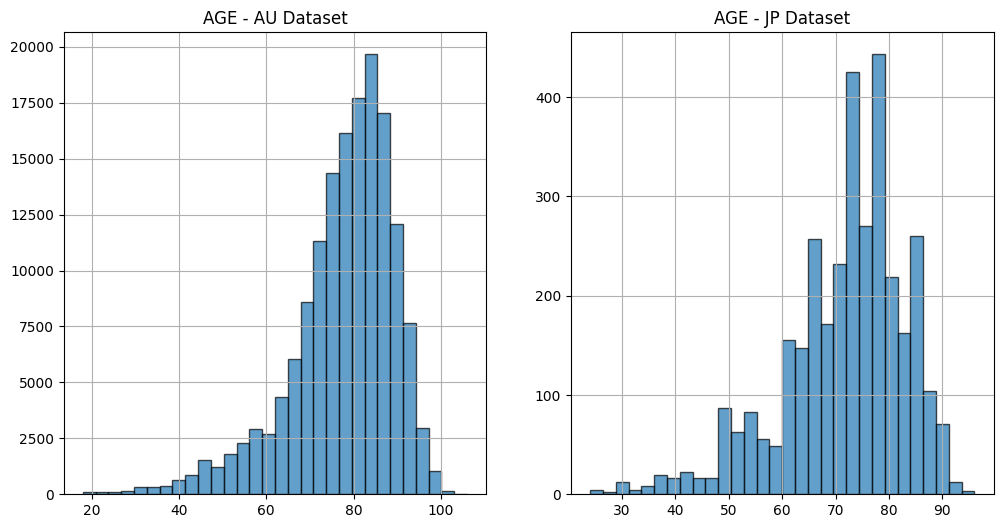

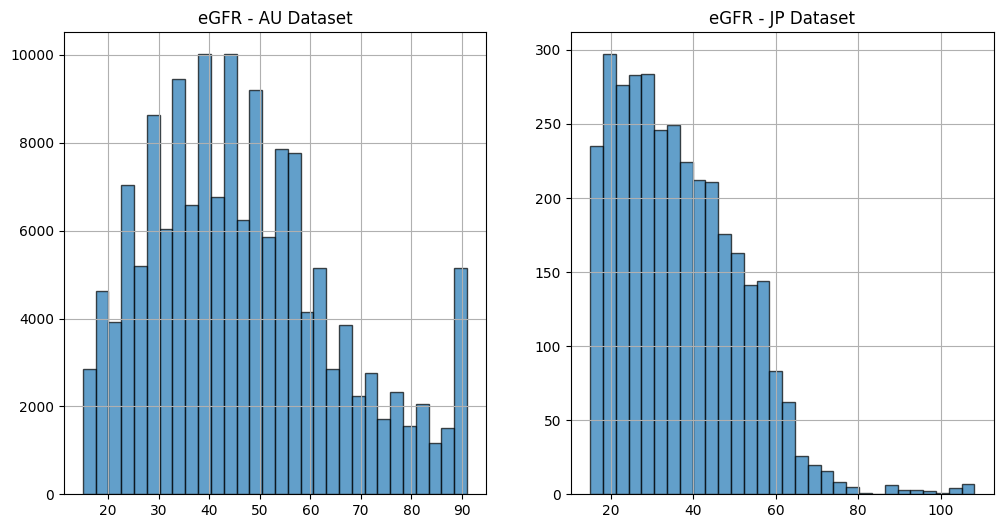

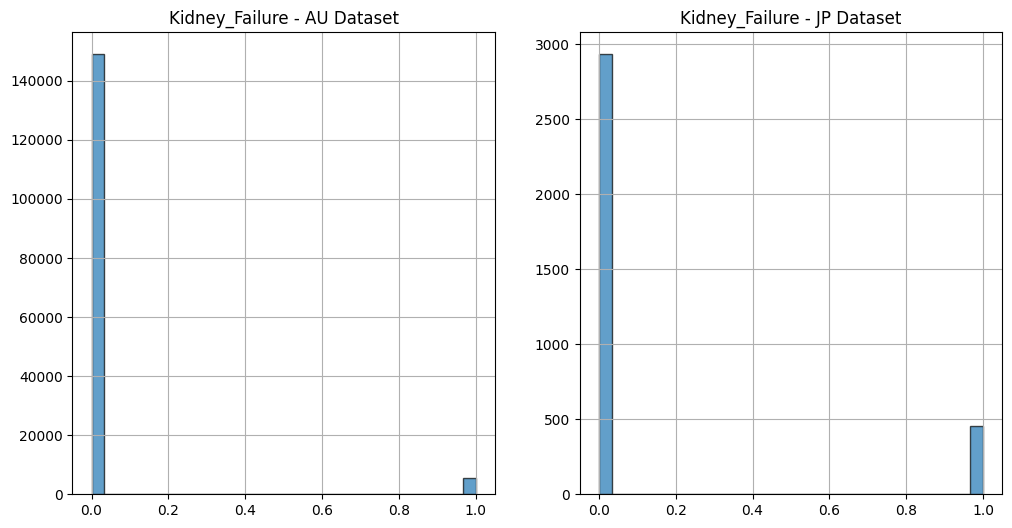

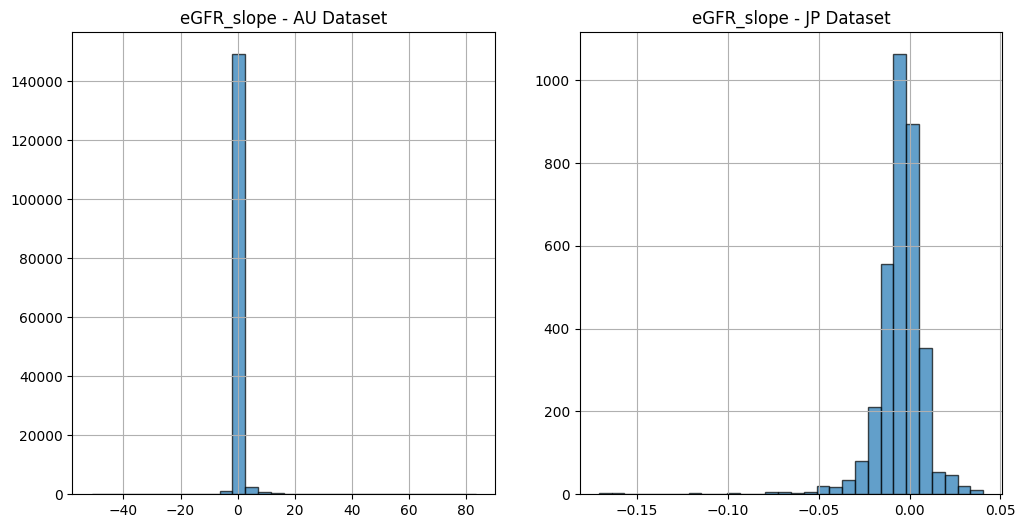

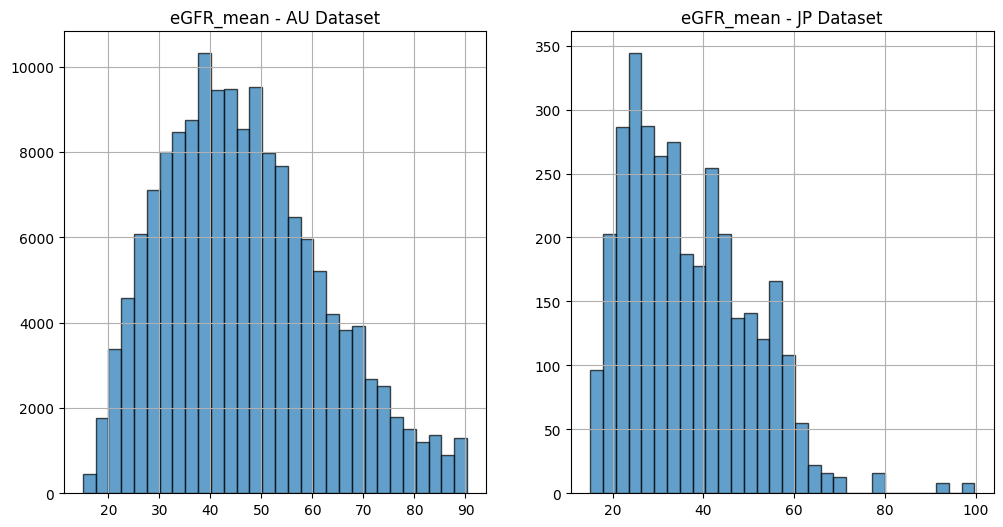

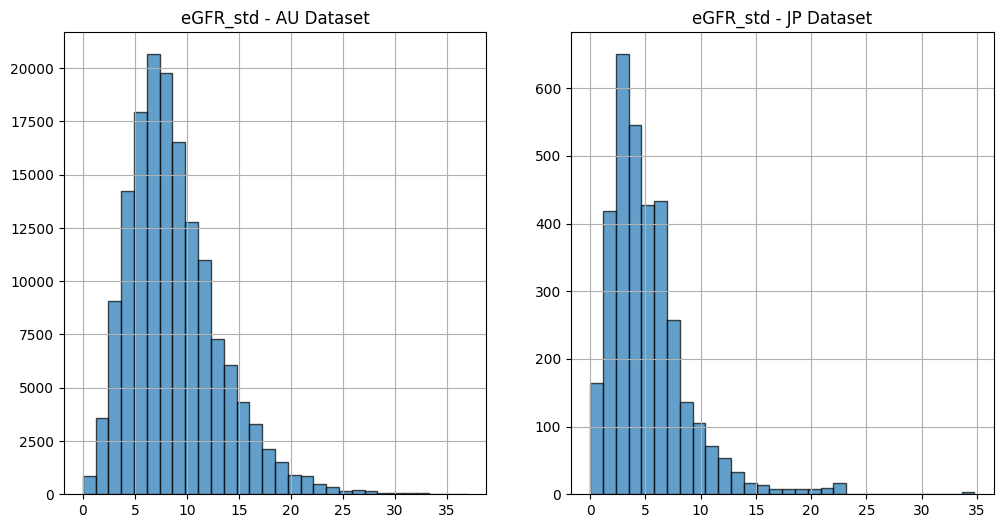

Summary statistics for AU Dataset:
                 SEX            AGE           eGFR  Kidney_Failure  \
count  154516.000000  154516.000000  154516.000000   154516.000000   
mean        1.489095      77.538371      46.642956        0.035873   
std         0.499883      12.017280      18.364515        0.185975   
min         1.000000      18.000000      15.000000        0.000000   
25%         1.000000      72.000000      33.000000        0.000000   
50%         1.000000      80.000000      44.000000        0.000000   
75%         2.000000      86.000000      58.000000        0.000000   
max         2.000000     106.000000      91.000000        1.000000   

          eGFR_slope      eGFR_mean       eGFR_std  
count  154516.000000  154516.000000  154516.000000  
mean        0.165648      46.642956       8.778338  
std         1.869981      15.705679       4.381331  
min       -51.135708      15.000000       0.000000  
25%        -0.014577      34.750000       5.718781  
50%        -0.00

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming AU_df and JP_df are already loaded DataFrames
# Select the features you are interested in
features = ['SEX', 'AGE', 'eGFR', 'Kidney_Failure', 'eGFR_slope', 'eGFR_mean', 'eGFR_std']

# Iterate over each feature and plot the distribution for both datasets
for feature in features:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    AU_df[feature].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{feature} - AU Dataset')

    plt.subplot(1, 2, 2)
    JP_df[feature].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{feature} - JP Dataset')

    plt.show()

# Display summary statistics for both datasets
print("Summary statistics for AU Dataset:")
print(AU_df[features].describe())

print("\nSummary statistics for JP Dataset:")
print(JP_df[features].describe())